<h1><center>Bayesian Computation project, Spring 2019</center></h1>
<center>Charles Dufour, Sciper: 257587</center>


In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [3]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot, compare_samples_MH,visualisation
from src.optimization import gradient_descent as GD

In [4]:
import src.maths.func_stats as fstats

# Load the data

In [5]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")
y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
X, X_test, Y, Y_test,y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

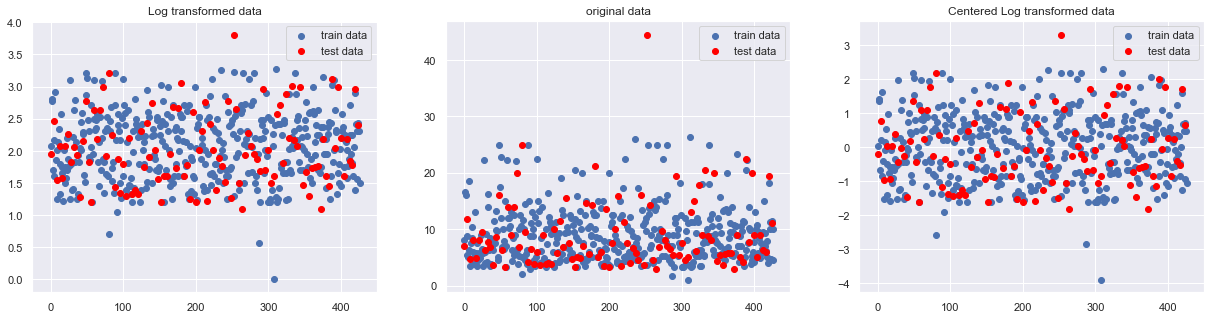

In [6]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

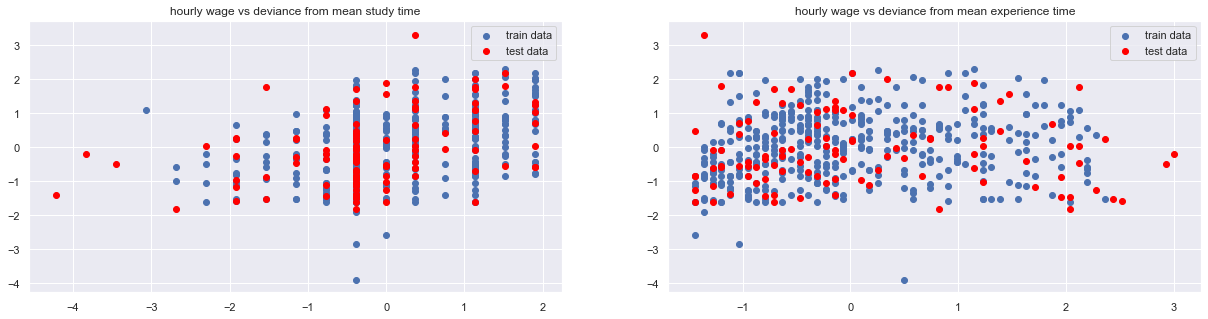

In [7]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.savefig("regressors.png",dpi = 300, bbox_inches = "tight")
plt.show()

# Create the models

`model_gausian`:

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


`model_student`:
    
- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$    

In [8]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

## Obtaining estimates of the parameters

## using MAP

#### using vanilla gradient descent

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$

Progress : [====================] 100% Done...
   duration: 0:00:14


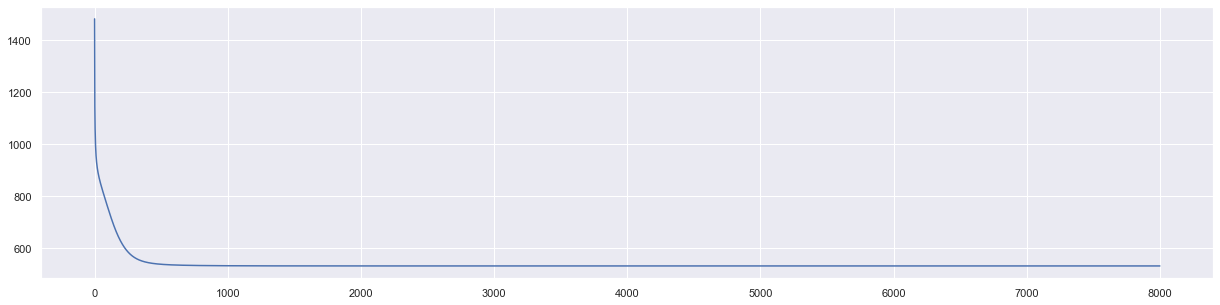

In [9]:
Value = GD.vanilla_gd(model_gaussian, max_iter= 8000, trace = True)
plt.plot(Value[1])
plt.show()

Progress : [====================] 100% Done...
   duration: 0:00:18


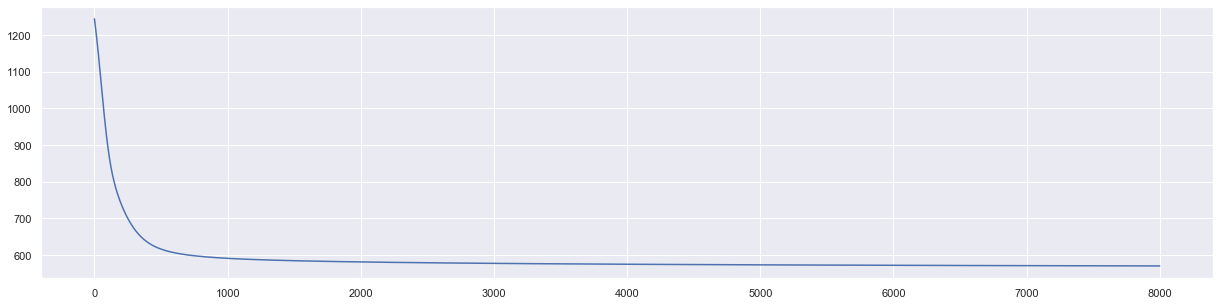

In [10]:
Value = GD.vanilla_gd(model_student, max_iter= 8000, trace = True)
plt.plot(Value[1])
plt.show()

#### using line search

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$
additional condition: accept if 
$$f(\theta_{n+1})< f(\theta_n) -\eta\epsilon||\nabla_\theta f(\theta_n)||_2^2$$

Progress : [====================] 100% Done...
 converged early at iteration 797  duration: 0:00:02


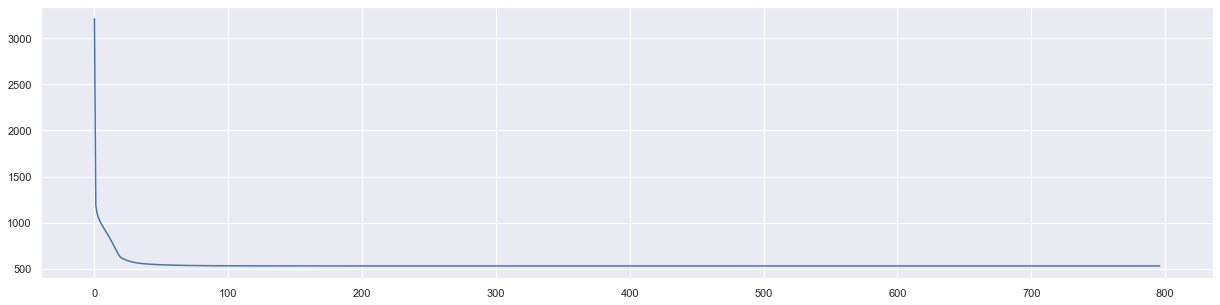

In [11]:
Value = GD.line_search_gd(model_gaussian, lambda_ = 1e-3,x0 = np.ones(model_gaussian.size),max_iter = 8000, trace = True)
plt.plot(Value[1])
plt.show()

Progress : [====================] 100% Done...
   duration: 0:00:25


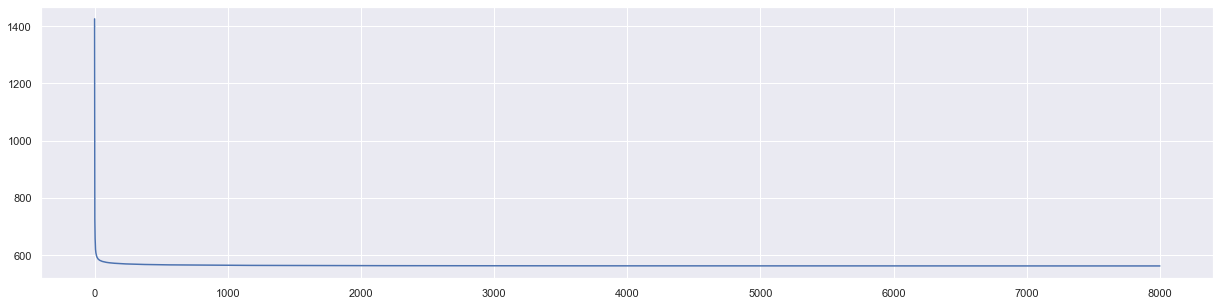

In [12]:
Value = GD.line_search_gd(model_student, lambda_ = 1e-2,x0 = np.ones(model_student.size),max_iter = 8000, trace = True)
plt.plot(Value[1])
plt.show()

#### using Wolfe condition to adpat the step size

Check the Wolfe condition and adapt the step size accordingly: $p_k = \nabla f(x_k)$,   $ \quad 0<c_1<c_2<1$

if $f(x_k + \alpha_kp_k) \leq f(x_k) + c_1\alpha_kp_k^T\nabla f(x_k)$  then reduce step size $\alpha_k$

if $-p_k^T\nabla f(x_k+\alpha_kp_k) \leq -c_2p_k^T\nabla f(x_k)$ then increase step size 

else accept update

Progress : [====================] 100% Done...
   duration: 0:00:56


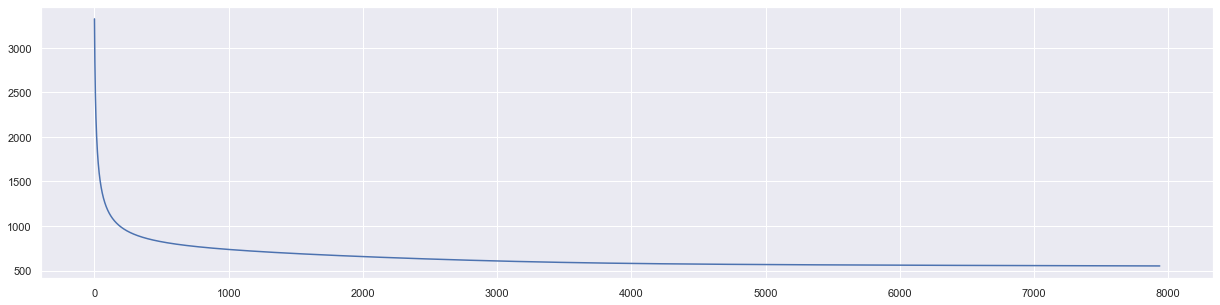

In [13]:
Value = GD.Wolfe_cond_gd(model_gaussian, max_iter = 8000, c1 = 1e-1, initial= 0.5*np.ones(model_gaussian.size),trace = True)
plt.plot(Value[1])
plt.show()

Progress : [====================] 100% Done...
   duration: 0:01:15


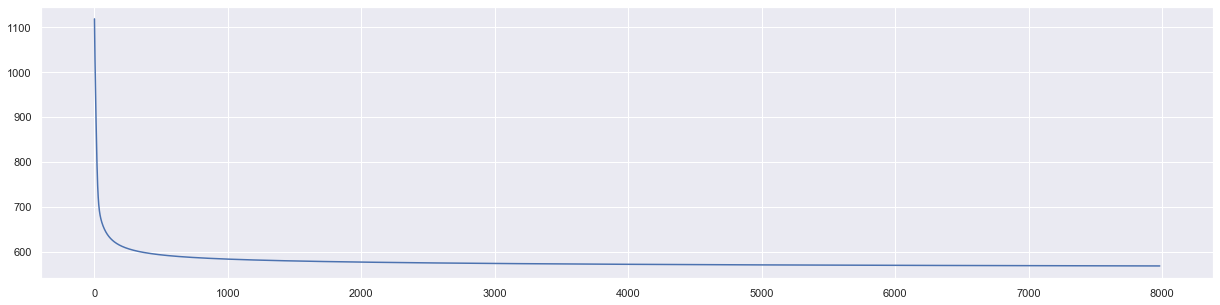

In [14]:
Value = GD.Wolfe_cond_gd(model_student, max_iter = 8000, c1 = 1e-1, initial= 0.5*np.ones(model_student.size), trace = True)
plt.plot(Value[1])
plt.show()

## Using Metropolis Hastings

#### with gaussian random walk

Progress : [====================] 100% Done...
  Acceptance rate : 16.4%  (advised values between 10% and 50%)
  duration: 0:00:11
iterations


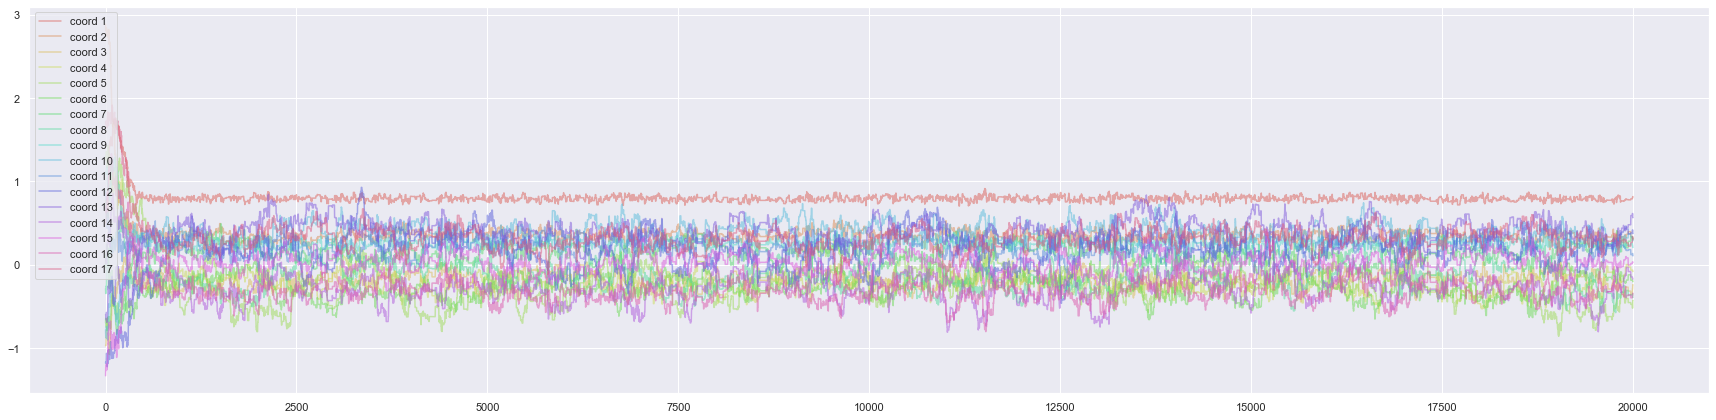

In [15]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_rw = MH.random_walk_MH(model_gaussian, max_iter = 20000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 40.2%  (advised values between 10% and 50%)
  duration: 0:00:13
iterations


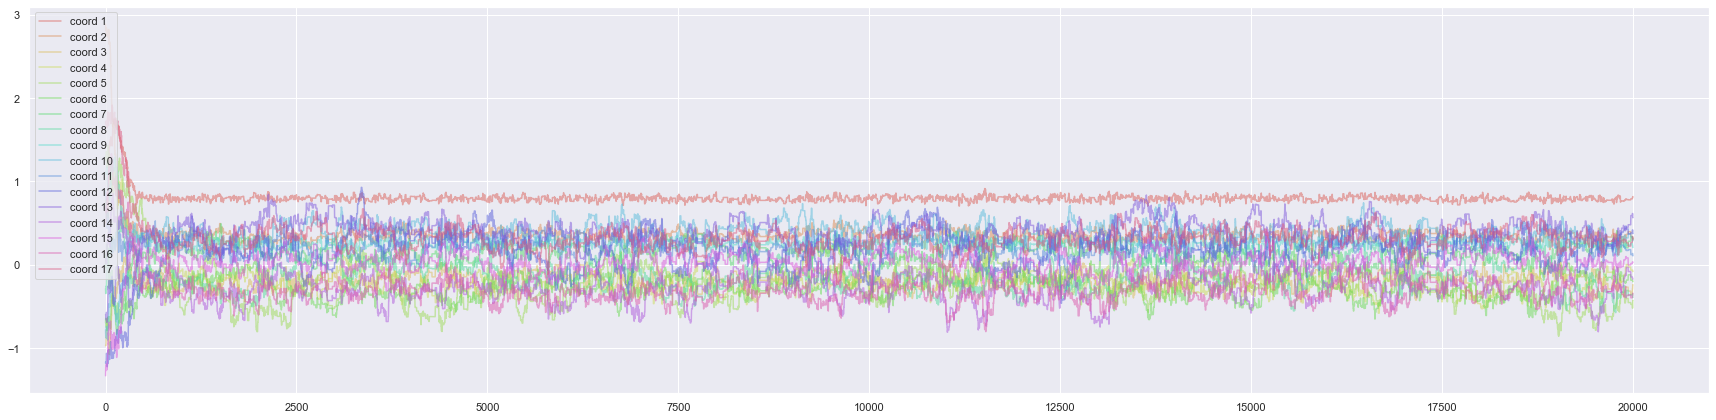

In [16]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 5
    samples_student_rw = MH.random_walk_MH(model_student, max_iter = 20000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

#### with Langevin correction

Progress : [====================] 100% Done...
  Acceptance rate : 59.7%                 (advised values between 10% and 50%)
  duration: 0:01:34
iterations


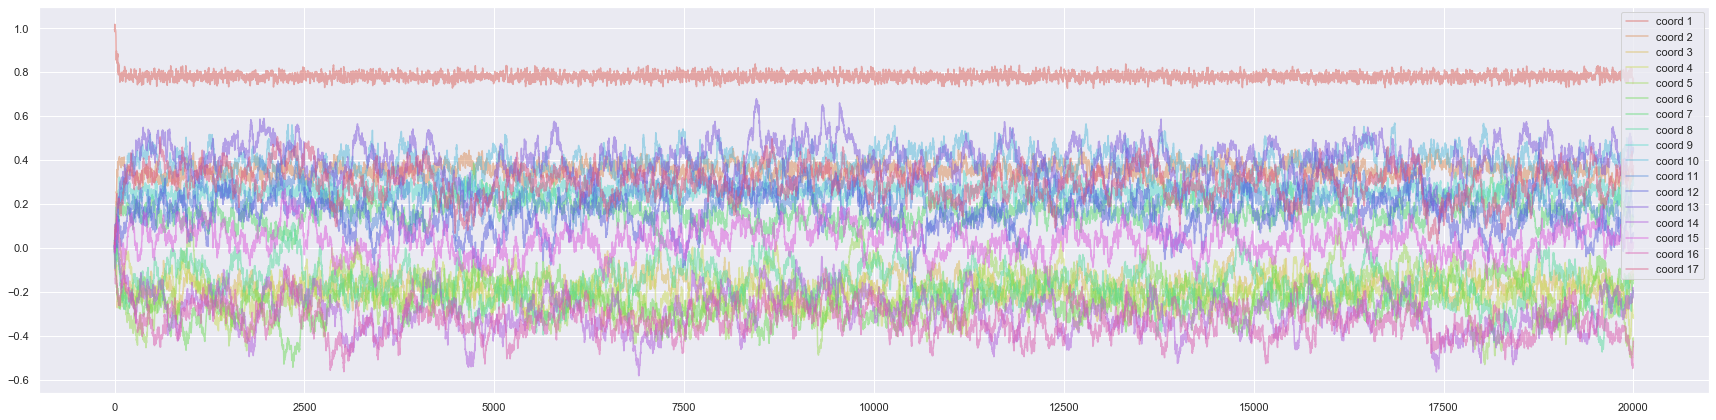

In [17]:
with warnings.catch_warnings(record=True):
    initial = np.zeros(model_gaussian.size)
    initial[0]=1
    samples_gaussian_langevin = MH.Langevin_MH(model_gaussian, max_iter = 20000, initial = initial,verbose = True, tau = 1e-4,RETURN=True)
    samples_exploration(samples_gaussian_langevin,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 25.4%                 (advised values between 10% and 50%)
  duration: 0:01:57
iterations


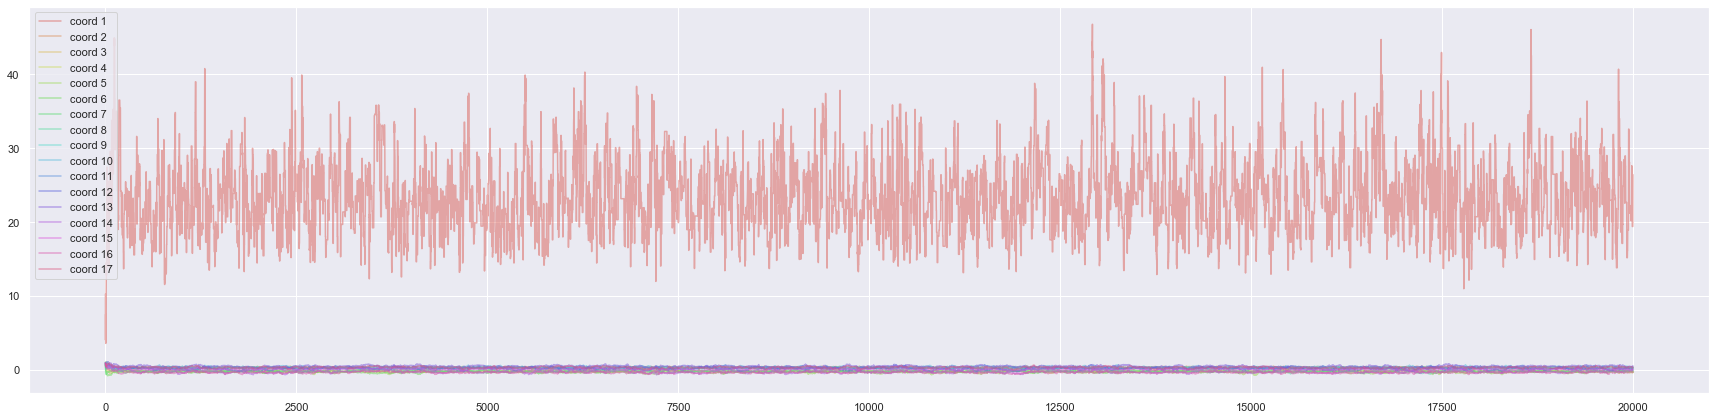

In [18]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    initial[0]=12
    step_size = np.ones(model_student.size)
    step_size[0] = 100
    samples_student_langevin = MH.Langevin_MH(model_student, max_iter = 20000, initial = initial, tau = 1e-3, RETURN=True,step_size = step_size)
    samples_exploration(samples_student_langevin,correlation=False, distribution = False)

#### comparison of the metropolis hastings chains

gaussian model

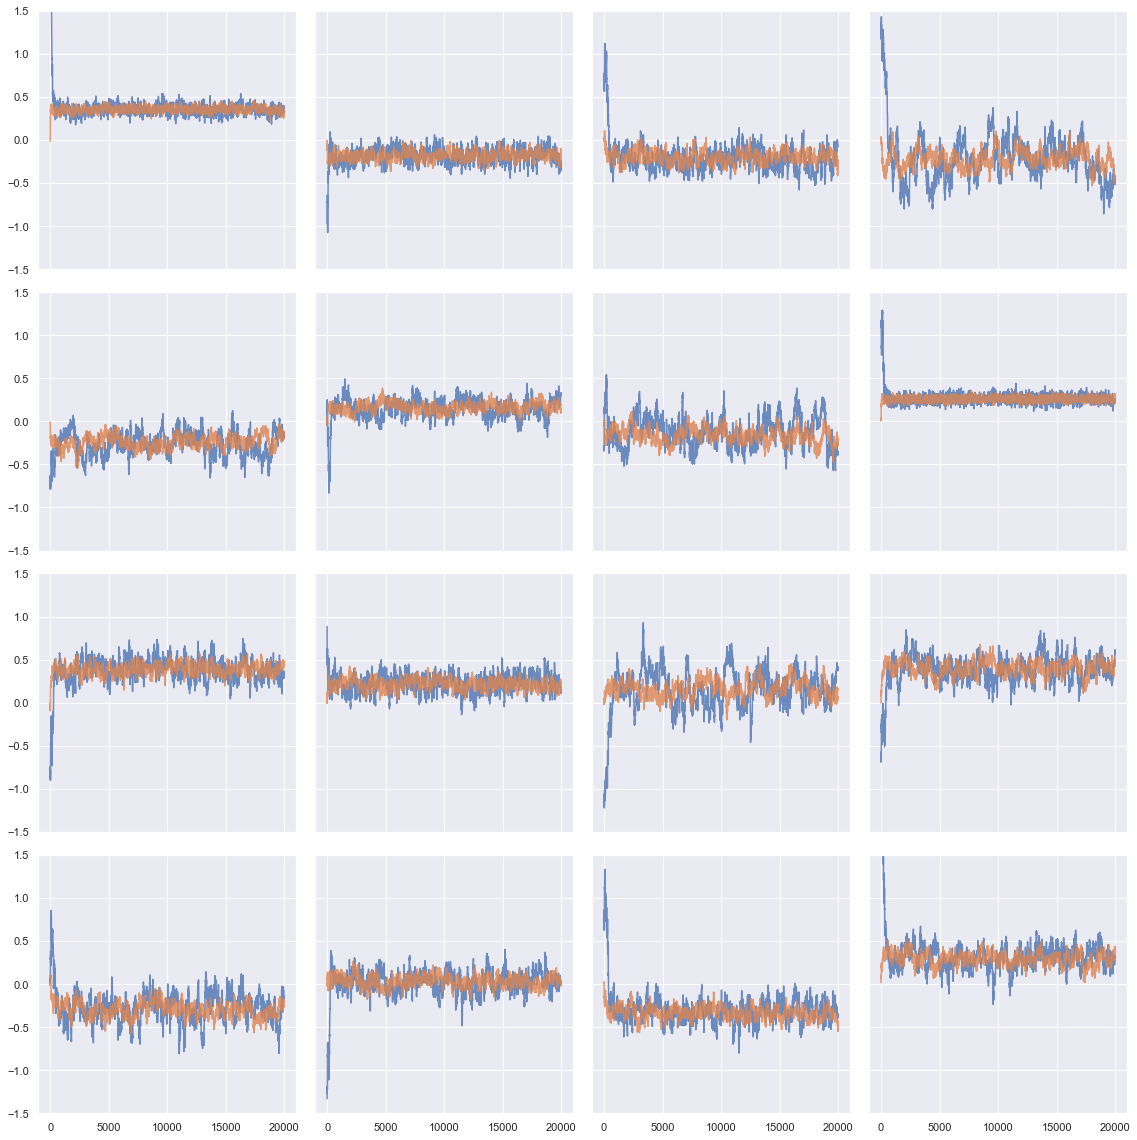

In [19]:
compare_samples_MH(samples_gaussian_rw,samples_gaussian_langevin)

student model

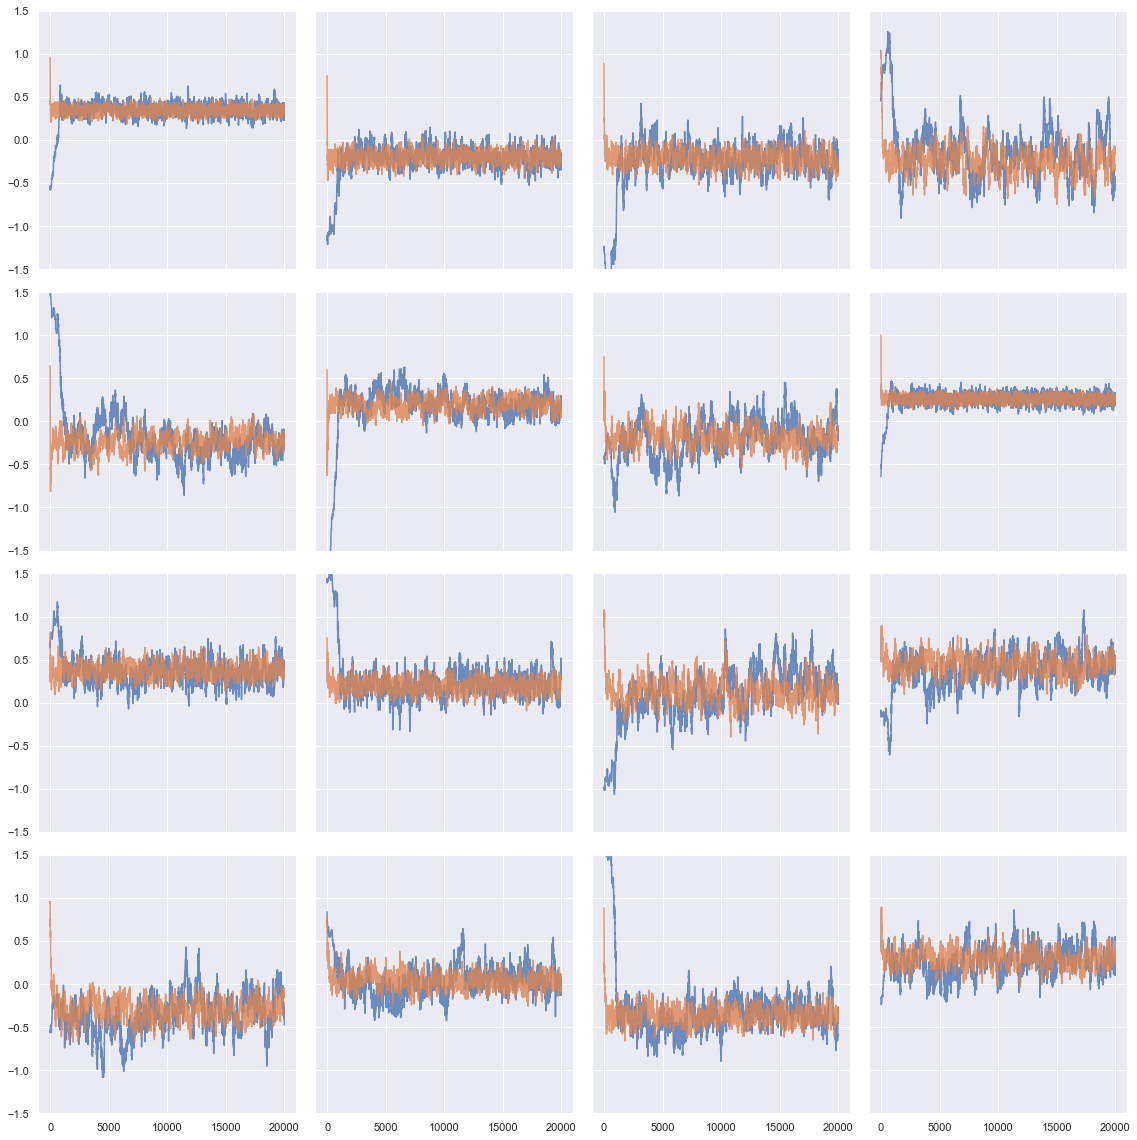

In [20]:
compare_samples_MH(samples_student_rw,samples_student_langevin)

### extraction of the estimates from the models

In [21]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH      HISP  \
gd                  0.773617  0.351707 -0.185607 -0.204573 -0.212706   
line_search_gd      0.773617  0.351707 -0.185607 -0.204573 -0.212708   
Wolfe_cond_gd       0.818362  0.425715 -0.141207  0.071222  0.339407   
MH_vanilla_mean     0.793133  0.353236 -0.177866 -0.225687 -0.242823   
MH_vanilla_median   0.792257  0.352931 -0.179953 -0.232558 -0.233514   
MH_Langevin_mean    0.779121  0.355395 -0.181166 -0.198969 -0.218081   
MH_Langevin_median  0.779216  0.354444 -0.182012 -0.200017 -0.222191   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.239067  0.169971 -0.162224  0.258266  0.385553   
line_search_gd     -0.239071  0.169967 -0.162219  0.258266  0.385554   
Wolfe_cond_gd      -0.358303 -0.125175 -0.051975  0.307898  0.360160   
MH_vanilla_mean    -0.266799  0.144840 -0.110606  0.260496  0.395246   
MH_vanilla_median  -0.267769  0.150963 -0.112235  0.258811  0.398562   
MH_Langevin_mean   -0.240079  0.167814 -0.166781  0.258869  0.388019   
MH_Langevin_median -0.238041  0.168756 -0.169313  0.258818  0.389127   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.212762  0.141787  0.393539 -0.297685  0.025751   
line_search_gd      0.212764  0.141789  0.393543 -0.297681  0.025755   
Wolfe_cond_gd       0.321533  0.439163  0.429924  0.276374  0.182567   
MH_vanilla_mean     0.219743  0.174524  0.400222 -0.280422  0.023869   
MH_vanilla_median   0.222309  0.171025  0.398526 -0.276182  0.024741   
MH_Langevin_mean    0.212051  0.161815  0.398238 -0.300096  0.029693   
MH_Langevin_median  0.212503  0.158841  0.404132 -0.297970  0.029936   

                        SERV      PROF  
gd                 -0.345086  0.297530  
line_search_gd     -0.345082  0.297534  
Wolfe_cond_gd       0.044369  0.354095  
MH_vanilla_mean    -0.320618  0.307505  
MH_vanilla_median  -0.321803  0.311008  
MH_Langevin_mean   -0.339867  0.290657  
MH_Langevin_median -0.341289  0.294632

In [22]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH      HISP  \
gd                   6.712007  0.339478 -0.204347 -0.240577 -0.297061   
line_search_gd      18.744119  0.341741 -0.197535 -0.220067 -0.256264   
Wolfe_cond_gd        7.886129  0.339471 -0.203319 -0.236226 -0.289781   
MH_vanilla_mean     24.427799  0.354839 -0.187515 -0.197704 -0.184889   
MH_vanilla_median   23.335863  0.355646 -0.191258 -0.201648 -0.181430   
MH_Langevin_mean    23.546905  0.344775 -0.197521 -0.212994 -0.255916   
MH_Langevin_median  23.122098  0.344644 -0.196499 -0.211604 -0.252308   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.265105  0.207199 -0.187967  0.264387  0.365791   
line_search_gd     -0.251051  0.190463 -0.178088  0.260819  0.373601   
Wolfe_cond_gd      -0.262365  0.204278 -0.186288  0.263679  0.366979   
MH_vanilla_mean    -0.239679  0.214608 -0.185167  0.262280  0.348143   
MH_vanilla_median  -0.246820  0.204711 -0.171175  0.262467  0.347498   
MH_Langevin_mean   -0.238560  0.195145 -0.184587  0.260214  0.379400   
MH_Langevin_median -0.233801  0.198284 -0.187518  0.260728  0.377396   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.205178  0.122440  0.503414 -0.280598  0.059471   
line_search_gd      0.206468  0.129351  0.461792 -0.290331  0.042638   
Wolfe_cond_gd       0.205153  0.123364  0.496686 -0.282771  0.056253   
MH_vanilla_mean     0.205940  0.155871  0.393741 -0.357478  0.018964   
MH_vanilla_median   0.207444  0.143604  0.396945 -0.357575  0.016818   
MH_Langevin_mean    0.199228  0.128729  0.446958 -0.301087  0.034760   
MH_Langevin_median  0.200645  0.127687  0.449445 -0.299508  0.034712   

                        SERV      PROF  
gd                 -0.359548  0.312959  
line_search_gd     -0.351271  0.308540  
Wolfe_cond_gd      -0.357893  0.312395  
MH_vanilla_mean    -0.367781  0.266104  
MH_vanilla_median  -0.374090  0.262060  
MH_Langevin_mean   -0.363682  0.298425  
MH_Langevin_median -0.365773  0.297334

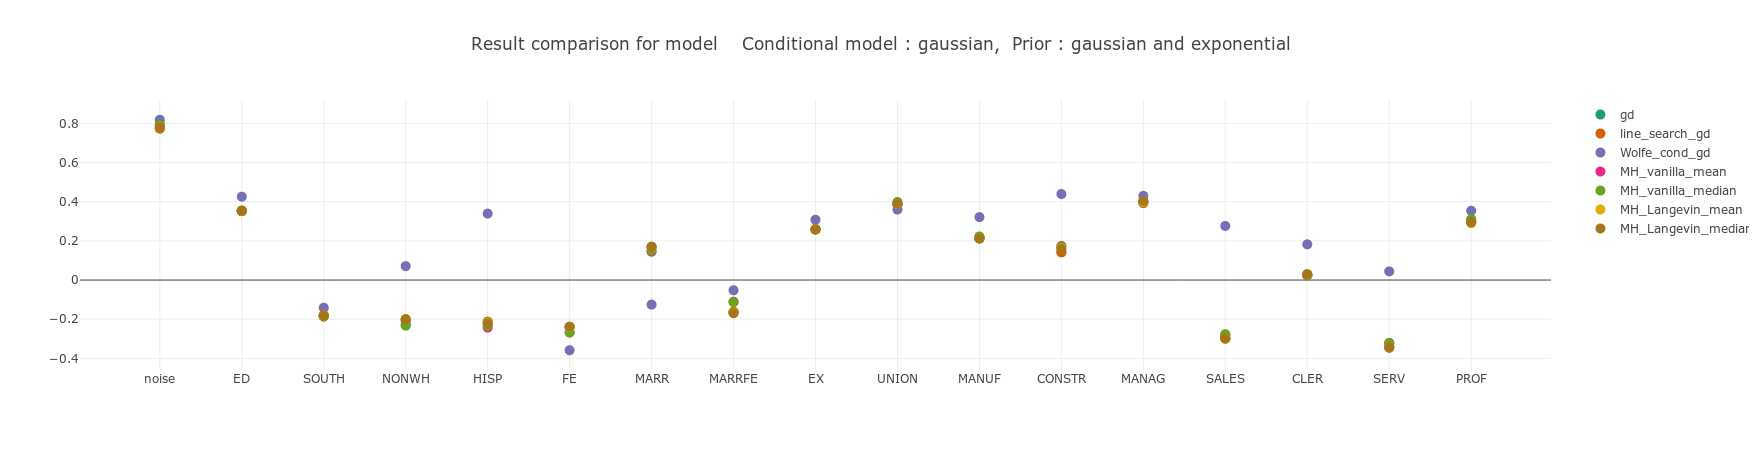

In [23]:
visualisation(r_gaussian,model_gaussian)

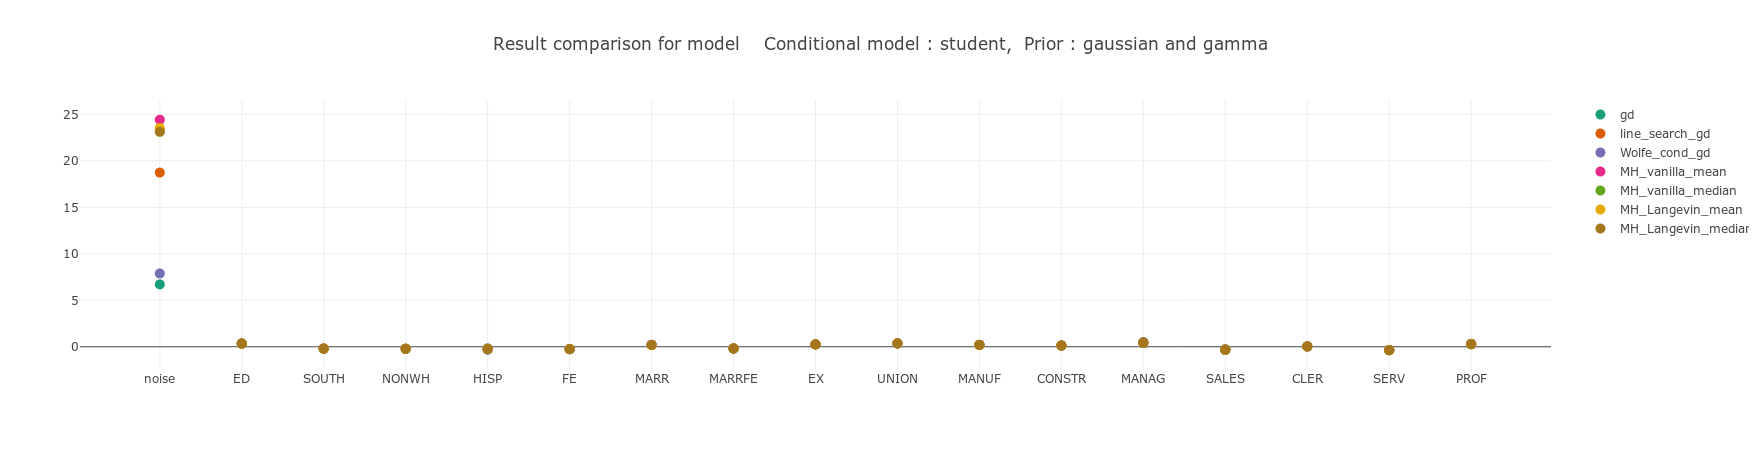

In [24]:
visualisation(r_student,model_student)

## Accuracy of the prediction

In order to predict, we have to use : $$ f(y| D = d) = \int f(y,\theta|D = d)d\theta = \int f(y|\theta)f(\theta|D=d)d\theta$$
Since we suppose our data are iid, the dependence of $y$ to $D$ is only through $\theta$



Supposing we want to approximate $y$ by its mean in the case of our first model, with the gaussian noise, gaussian prior on $\beta$ and exponential prior on $\sigma$:

\begin{align} \mathbb{E}[y|D=d] &= \int y f(y|D=d)dy \\
&= \int y \int f(y|\theta)f(\theta|D=d)d\theta dy \\
&= \int\int y f(y|\theta)f(\theta|D=d)d\theta dy\\
&= \int\left( \int y f(y|\theta)dy \right) f(\theta|D=d)d\theta \\
&= \int x^T\beta f(\theta|D=d)d\theta \\ 
&= \mathbb{E}_{\theta \sim \theta|D=d}[x^T\beta]\\
&= x^T \widehat{\beta}
\end{align}

So supposing we can switch the integrals (using Fubini since both functions are positive (densities) and the integral $\int y f(y|\theta)f(\theta|D=d)d\theta dy $ is finite ), the point prediction can be done by either marginalizing out the $\theta$, or by first finding the "optimal" theta and then predicting the MAP of the conditional model. This is logic given that the marginalization of the $\theta$ is there because we do not know the distribution of the $\theta$, but only its distribution. But if we are interested in a point estimate, this inflation in the uncertainty of our precision is not directly usefull.


For our second model, the same development holds.

Otherwise we could just use the samples from the previous run of our Metropolis Hasting algorithms and for each $\theta$ sampled, compute a prediction $x^T\theta$ and then compute a statistic on these. 

When using the samples from Metropolis-Hastings algorithm, we will make a gaussian approximation of our posterior, so the MAP will be the mean or the median. Since this is an approximation, we will use both mean and median to see if there is any discrepancies in our reasonning.

In [25]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_gaussian.index = ["error on test","error on train"]
errors_gaussian.T

error on test  error on train
gd                       0.685706        0.613765
line_search_gd           0.685706        0.613765
Wolfe_cond_gd            0.692771        0.651932
MH_vanilla_mean          0.686627        0.614059
MH_vanilla_median        0.686784        0.613866
MH_Langevin_mean         0.684998        0.613687
MH_Langevin_median       0.685120        0.613437

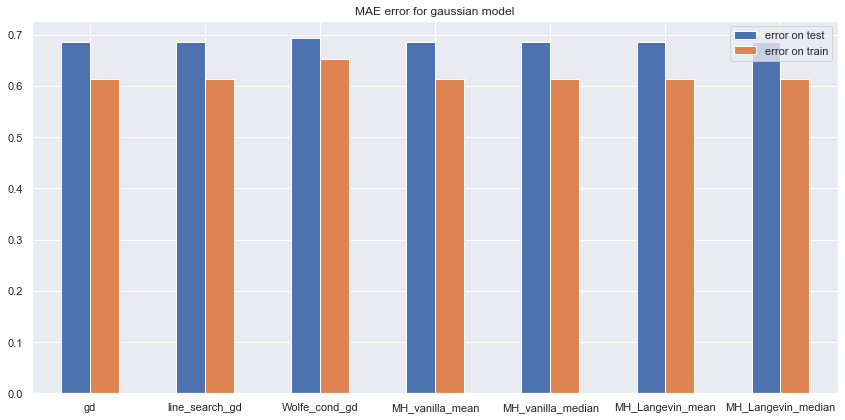

In [26]:
big_plot(12,6)
errors_gaussian.T.plot.bar()
plt.xticks(rotation="horizontal")
plt.title("MAE error for gaussian model")
plt.tight_layout()
reset_plot()

In [27]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_student.index = ["error on test","error on train"]
errors_student.T

error on test  error on train
gd                       0.685289        0.609905
line_search_gd           0.685159        0.611209
Wolfe_cond_gd            0.685230        0.610147
MH_vanilla_mean          0.686226        0.613365
MH_vanilla_median        0.686735        0.613205
MH_Langevin_mean         0.686076        0.611171
MH_Langevin_median       0.686665        0.611080

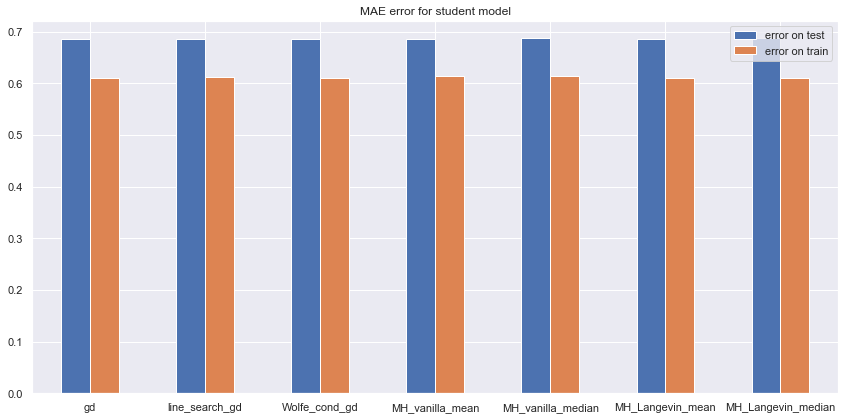

In [28]:
big_plot(12,6)
errors_student.T.plot.bar()
plt.xticks(rotation="horizontal")
plt.title("MAE error for student model")
plt.tight_layout()
reset_plot()

# Classification 

`multilogi`:

- Conditional model
$$\mathbb{P}\left(Y=1|X\right) = \frac{e^{X^T\beta}}{1+e^{X^T\beta}}$$

- Prior:
$$\beta \sim N(0,3^2I) $$

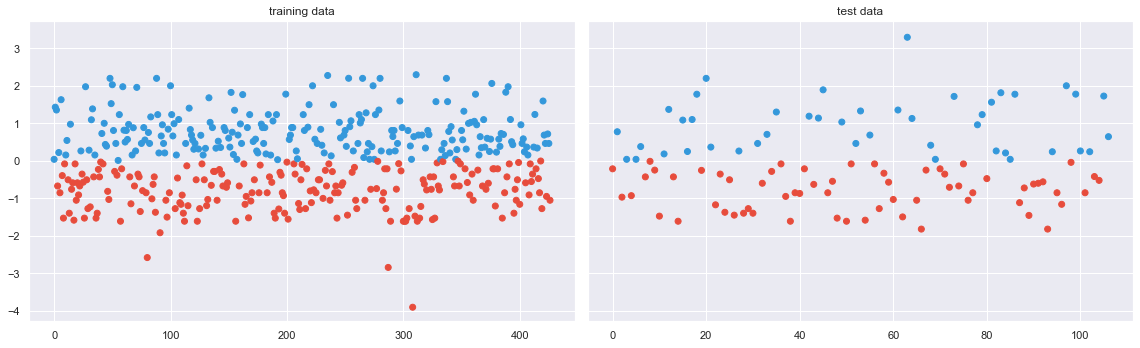

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

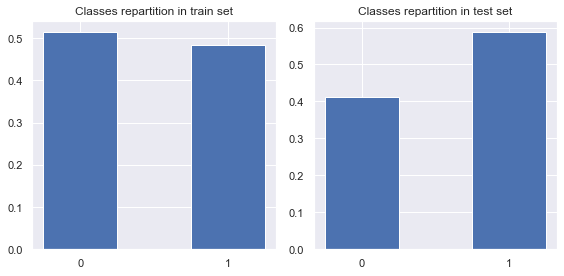

In [30]:
plt.subplot(121)
plt.bar([0.4,0.8],[len(classes[classes==0])/len(classes),len(classes[classes==1])/len(classes)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in train set")
plt.subplot(122)
plt.bar([0.4,0.8],[len(classes_test[classes_test==0])/len(classes_test),len(classes_test[classes_test==1])/len(classes_test)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in test set")
plt.tight_layout()
plt.show()

In [31]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X,response = classes, Prior = [0,3*np.ones(16)],cond_model = [2])

In [32]:
GD.vanilla_gd(multilogi, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:07


In [33]:
GD.line_search_gd(multilogi, lambda_ = 1e-3,x0 = np.ones(multilogi.size),max_iter = 8000)

Progress : [====================] 100% Done...
 converged early at iteration 5606  duration: 0:00:06


In [34]:
GD.Wolfe_cond_gd(multilogi, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(multilogi.size))

Progress : [====================] 100% Done...
   duration: 0:00:12


Progress : [====================] 100% Done...
  Acceptance rate : 38.1%  (advised values between 10% and 50%)
  duration: 0:00:23
iterations


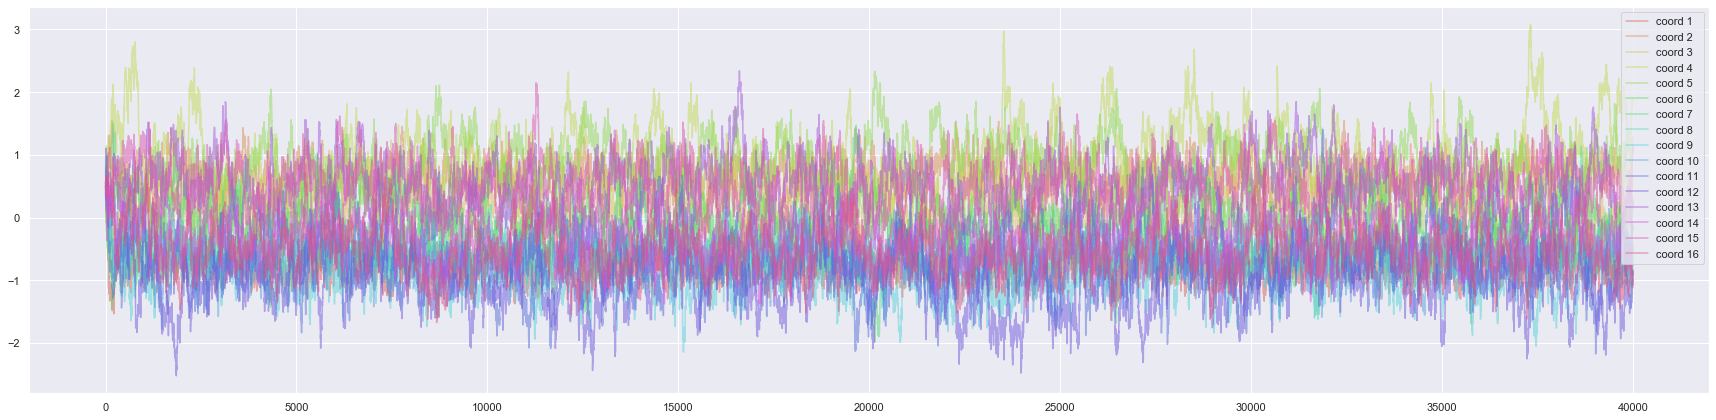

In [35]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_rw = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_rw, distribution=False, correlation= False)

Progress : [====================] 100% Done...
  Acceptance rate : 18.0%                 (advised values between 10% and 50%)
  duration: 0:01:17
iterations


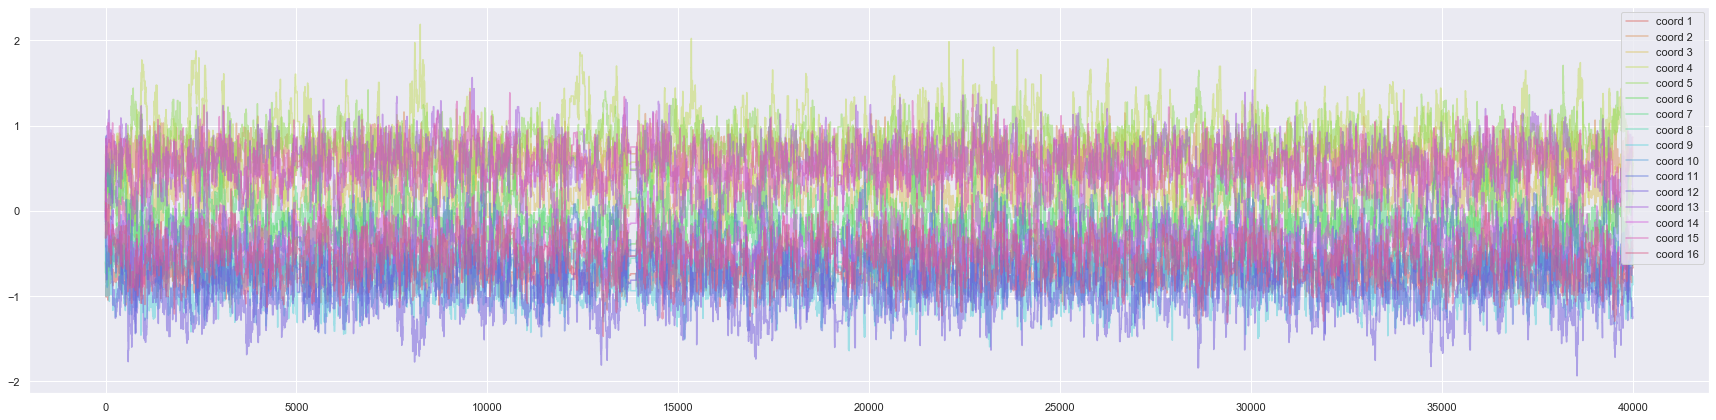

In [36]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_langevin = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)
    samples_exploration(samples_classification_langevin, distribution=False, correlation= False)

In [37]:
r_multilogi = multilogi()
r_multilogi.T

ED     SOUTH     NONWH      HISP        FE  \
gd                 -0.744104  0.641370  0.201931  0.730057  0.764238   
line_search_gd     -0.745740  0.637126  0.198143  0.750089  0.749299   
Wolfe_cond_gd      -0.745817  0.637126  0.198003  0.749741  0.748650   
MH_vanilla_mean    -0.789857  0.661789  0.206872  0.828236  0.827805   
MH_vanilla_median  -0.785686  0.664194  0.194385  0.793269  0.806844   
MH_Langevin_mean   -0.762605  0.645282  0.193033  0.758554  0.755525   
MH_Langevin_median -0.761553  0.648865  0.194318  0.731242  0.760260   

                        MARR    MARRFE        EX     UNION     MANUF  \
gd                 -0.265575 -0.104887 -0.567432 -0.870528 -0.650946   
line_search_gd     -0.276186 -0.094773 -0.566730 -0.871967 -0.642510   
Wolfe_cond_gd      -0.276601 -0.094112 -0.566733 -0.871869 -0.642297   
MH_vanilla_mean    -0.269030 -0.154513 -0.588590 -0.925025 -0.688519   
MH_vanilla_median  -0.269394 -0.127409 -0.587810 -0.923386 -0.686146   
MH_Langevin_mean   -0.287747 -0.089006 -0.578444 -0.887339 -0.654132   
MH_Langevin_median -0.292508 -0.095379 -0.577816 -0.887097 -0.651298   

                      CONSTR     MANAG     SALES      CLER      SERV      PROF  
gd                 -0.507148 -0.979912  0.494951 -0.358567  0.504844 -0.579711  
line_search_gd     -0.481143 -0.962650  0.510775 -0.344109  0.521019 -0.564106  
Wolfe_cond_gd      -0.480883 -0.962098  0.511308 -0.343662  0.521453 -0.563554  
MH_vanilla_mean    -0.554689 -1.016453  0.495354 -0.379664  0.510429 -0.564350  
MH_vanilla_median  -0.567416 -1.001688  0.501541 -0.386933  0.504032 -0.569551  
MH_Langevin_mean   -0.483325 -0.959555  0.541571 -0.349878  0.536004 -0.558074  
MH_Langevin_median -0.490290 -0.954085  0.538129 -0.348829  0.531110 -0.555754

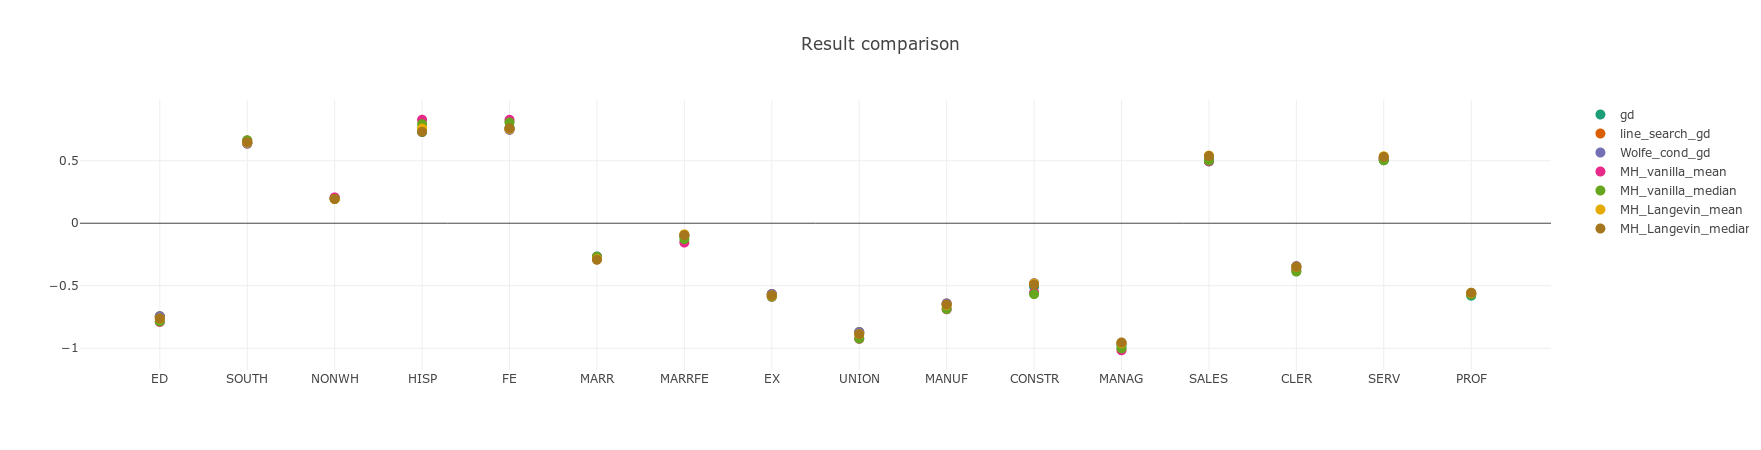

In [38]:
visualisation(r_multilogi,multilogi)

## Results of logistic regression

In order to predict, we will minimize the misclassification error, which mean we will use the decision boundary $\mathbb{P}[Y=1|x]>=0.5$.

Following Bishop _Pattern recognition and Machine learning_, p.220, we first compute the MAP of our parameter $\beta$, and then use it to predict our classes using the decisin boundary above.

When using the samples from Metropolis-Hastings algorithm, we will make a gaussian approximation of our posterior, so the MAP will be the mean or the median. Since this is an approximation, we will use both mean and median to see if there is any discrepancies in our reasonning.

In [39]:
predictions = multilogi.predict(X_test)
fitted = multilogi.predict(X)

In [40]:
errors = {}

In [41]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes_test))
    else:
        errors[name] = [error/len(classes_test)]

In [42]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes))
    else:
        errors[name] = [error/len(classes)]

In [43]:
errors = pd.DataFrame(errors)
errors.index = ["error on test", "error on train"]
errors.T

error on test  error on train
gd                       0.467290        0.271663
line_search_gd           0.467290        0.269321
Wolfe_cond_gd            0.467290        0.269321
MH_vanilla_mean          0.476636        0.266979
MH_vanilla_median        0.467290        0.269321
MH_Langevin_mean         0.467290        0.269321
MH_Langevin_median       0.467290        0.269321

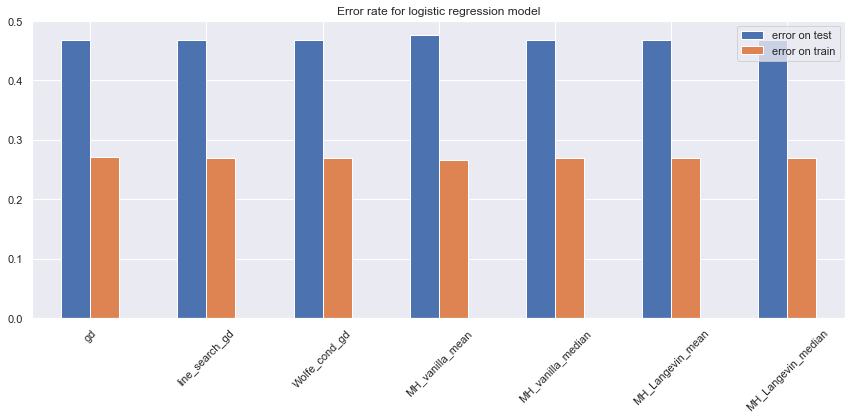

In [44]:
big_plot(12,6)
errors.T.plot.bar()
plt.xticks(rotation=45)
plt.title("Error rate for logistic regression model")
plt.tight_layout()
reset_plot()